In [6]:
import os
import numpy as np
from matplotlib import pyplot as plt
import glob
import pickle
import random

import tensorflow as tf
from tensorflow.keras.callbacks import CSVLogger

from keras.models import load_model
from keras.models import Model
from keras.layers import Input, Conv3D, MaxPooling3D, concatenate, Conv3DTranspose, BatchNormalization, Dropout, Lambda
from keras.optimizers import Adam
from keras.metrics import MeanIoU
import keras.backend as K


# import keras
# from custom_datagen import imageLoader

# python -m pip uninstall segmentation-models-3D




# import segmentation_models_3D as sm


kernel_initializer =  'he_uniform' #Try others if you want


2024-01-16 15:54:54.560782: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-16 15:54:54.560869: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-16 15:54:54.562114: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-16 15:54:54.571595: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-16 15:54:55.854811: W tensorflow/compiler/tf2

In [7]:
# Set GPU device
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
if gpus:
    # Restrict TensorFlow to only allocate memory on the first GPU
    try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
1 Physical GPUs, 1 Logical GPU


2024-01-16 15:55:13.942867: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9803 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:21:00.0, compute capability: 7.5


In [8]:
def load_img(img_dir, img_list):
    images=[]
    for i, image_name in enumerate(img_list):    
        if (image_name.split('.')[1] == 'npy'):
            
            image = np.load(img_dir+image_name)
                      
            images.append(image)
    images = np.array(images)
    
    return(images)



def imageLoader(img_dir, img_list, mask_dir, mask_list, batch_size):

    L = len(img_list)

    #keras needs the generator infinite, so we will use while true  
    while True:

        batch_start = 0
        batch_end = batch_size

        while batch_start < L:
            limit = min(batch_end, L)
                       
            X = load_img(img_dir, img_list[batch_start:limit])
            Y = load_img(mask_dir, mask_list[batch_start:limit])

            yield (X,Y) #a tuple with two numpy arrays with batch_size samples     

            batch_start += batch_size   
            batch_end += batch_size


In [9]:
train_img_dir = "BraTS2020_TrainingData/input_data_128/train/images/"
train_mask_dir = "BraTS2020_TrainingData/input_data_128/train/masks/"

val_img_dir = "BraTS2020_TrainingData/input_data_128/val/images/"
val_mask_dir = "BraTS2020_TrainingData/input_data_128/val/masks/"

train_img_list = sorted(os.listdir(train_img_dir))
train_mask_list = sorted(os.listdir(train_mask_dir))

val_img_list = sorted(os.listdir(val_img_dir))
val_mask_list = sorted(os.listdir(val_mask_dir))

val_mask_list[0],val_mask_list[0], train_img_list[0], train_mask_list[0]

('mask_00000.npy', 'mask_00000.npy', 'image_00002.npy', 'mask_00002.npy')

In [10]:
# #Load model for prediction or continue training

# #For continuing training....
# #The following gives an error: Unknown loss function: dice_loss_plus_1focal_loss
# #This is because the model does not save loss function and metrics. So to compile and 
# #continue training we need to provide these as custom_objects.
# my_model = load_model('saved_models/brats_3d_100epochs_simple_unet_weighted_dice.hdf5')

# #So let us add the loss as custom object... but the following throws another error...
# #Unknown metric function: iou_score
# my_model = load_model('saved_models/brats_3d_100epochs_simple_unet_weighted_dice.hdf5', 
#                       custom_objects={'dice_loss_plus_1focal_loss': total_loss})

# #Now, let us add the iou_score function we used during our initial training
# my_model = load_model('saved_models/brats_3d_100epochs_simple_unet_weighted_dice.hdf5', 
#                       custom_objects={'dice_loss_plus_1focal_loss': total_loss,
#                                       'iou_score':sm.metrics.IOUScore(threshold=0.5)})

In [11]:
#For predictions you do not need to compile the model, so ...
model = load_model('brats_3d.hdf5', compile=False)

In [16]:

"""Compute metric between the predicted segmentation and the ground truth
"""

def dice_coef(y_true, y_pred, smooth=1.0):
    class_num = 4
    for i in range(class_num):
        y_true_f = K.flatten(y_true[:,:,:,i])
        y_pred_f = K.flatten(y_pred[:,:,:,i])
        intersection = K.sum(y_true_f * y_pred_f)
        loss = ((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))
        if i == 0:
            total_loss = loss
        else:
            total_loss = total_loss + loss
    total_loss = total_loss / class_num
    return total_loss


# ===============================================================
# ===============================================================
# ===============================================================

# define per class evaluation of dice coef
def dice_coef_necrotic(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,1] * y_pred[:,:,:,1]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,1])) + K.sum(K.square(y_pred[:,:,:,1])) + epsilon)

def dice_coef_edema(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,2] * y_pred[:,:,:,2]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,2])) + K.sum(K.square(y_pred[:,:,:,2])) + epsilon)

def dice_coef_enhancing(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,3] * y_pred[:,:,:,3]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,3])) + K.sum(K.square(y_pred[:,:,:,3])) + epsilon)

# ===============================================================
# ===============================================================
# ===============================================================

def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())


def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

# ===============================================================
# ===============================================================
# ===============================================================

metrics = ['accuracy',
           tf.keras.metrics.MeanIoU(num_classes=4),
           tf.keras.metrics.Precision(),
           tf.keras.metrics.Recall(),
           tf.keras.metrics.SpecificityAtSensitivity(0.5),
           tf.keras.metrics.SensitivityAtSpecificity(0.5),
           dice_coef, dice_coef_necrotic, dice_coef_edema, dice_coef_enhancing]


model.compile(loss="categorical_crossentropy", 
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
              metrics = metrics)

In [17]:
with open('model_history.pickle', 'rb') as file_pi:
    history = pickle.load(file_pi)

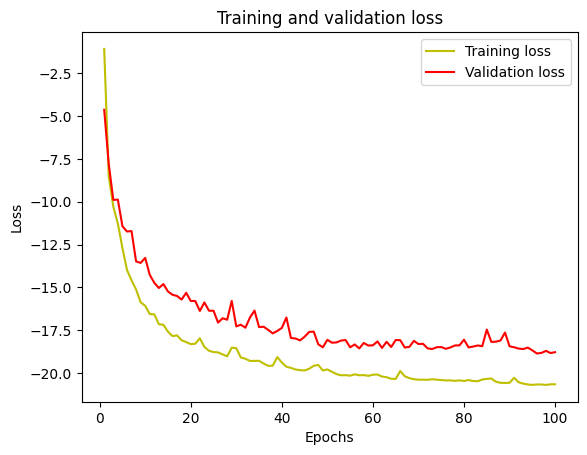

In [18]:
#plot the training and validation IoU and loss at each epoch
loss = history['loss']
val_loss = history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [19]:
#Verify IoU on a batch of images from the test dataset
#Using built in keras function for IoU
batch_size=8 #Check IoU for a batch of images
test_img_datagen = imageLoader(val_img_dir, val_img_list, 
                                val_mask_dir, val_mask_list, batch_size)

In [20]:
#Verify generator.... In python 3 next() is renamed as __next__()
test_image_batch, test_mask_batch = test_img_datagen.__next__()

In [21]:
test_image_batch.shape, test_mask_batch.shape

((8, 128, 128, 128, 4), (8, 128, 128, 128, 4))

In [23]:
test_mask_batch_argmax = np.argmax(test_mask_batch, axis=4)
test_pred_batch = model.predict(test_image_batch)
test_pred_batch_argmax = np.argmax(test_pred_batch, axis=4)

2024-01-16 16:01:01.385821: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-01-16 16:01:01.510517: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-16 16:01:02.609149: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


1/1 [==============================] - 14s 14s/step


In [24]:
n_classes = 4
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(test_pred_batch_argmax, test_mask_batch_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.8654201


In [26]:
#############################################
#Predict on a few test images, one at a time
#Try images: 
img_num_test = '00012'
img_num_val = '00000'


test_img = np.load("BraTS2020_TrainingData/input_data_128/test/images/image_"+img_num_test+".npy")

test_mask = np.load("BraTS2020_TrainingData/input_data_128/test/masks/mask_"+img_num_test+".npy")
test_mask_argmax=np.argmax(test_mask, axis=3)

test_img_input = np.expand_dims(test_img, axis=0)
test_prediction = model.predict(test_img_input)
test_prediction_argmax=np.argmax(test_prediction, axis=4)[0,:,:,:]

1/1 [==============================] - 2s 2s/step


In [27]:
print(test_prediction_argmax.shape)
print(test_mask_argmax.shape)
print(np.unique(test_prediction_argmax))

(128, 128, 128)
(128, 128, 128)
[0 1 2 3]


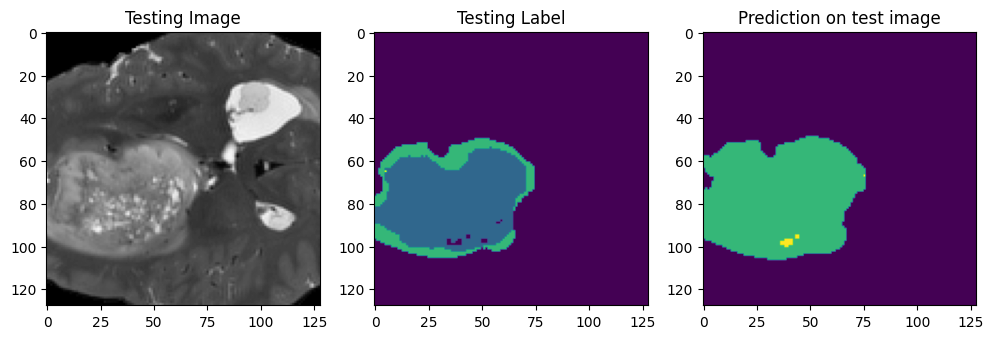

In [31]:
#Plot individual slices from test predictions for verification
n_slice=random.randint(0, test_prediction_argmax.shape[2])
# n_slice = 55
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,n_slice,1], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(test_mask_argmax[:,:,n_slice])
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction_argmax[:,:, n_slice])
plt.show()

In [32]:
# !tensorboard --logdir=./logs
# !tensorboard --logdir=./logs --bind_all

In [36]:
# IMG_SIZE=128
# # [56:184, 56:184, 13:141]
# # Define selected slices range
# VOLUME_START_AT = 0 
# VOLUME_SLICES = 256
# N_CHANNELS = 2 # Number of channels (==2: "T1CE + FLAIR") !! Change vals in __data_generation when modify this param!


# # data_path = '/data/segmentation/train'
# figs_path = '/group/bagel/Task_1.B/MRI_Segmentation_and_TumorClassification/Brata2020_Unet_segmentation/figures'
# evaluation_path = '/group/bagel/Task_1.B/MRI_Segmentation_and_TumorClassification/Brata2020_Unet_segmentation'

# # def plot_acc_loss_iou(show_plot=True, save_path=None):
    
# # Read the CSVlogger file that contains all our metrics (accuracy, loss, dice_coef, ...) of our training
# # history = pd.read_csv('training.log', sep=',', engine='python')

# # Plot training and validation metrics
# fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# axs[0].plot(history['epoch'], history['accuracy'], 'b', label='Training Accuracy')
# axs[0].plot(history['epoch'], history['val_accuracy'], 'r', label='Validation Accuracy')
# axs[0].set_xlabel('Epoch')
# axs[0].set_ylabel('Accuracy')
# axs[0].legend()

# axs[1].plot(history['epoch'], history['loss'], 'b', label='Training Loss')
# axs[1].plot(history['epoch'], history['val_loss'], 'r', label='Validation Loss')
# axs[1].set_xlabel('Epoch')
# axs[1].set_ylabel('Loss')
# axs[1].legend()

# # axs[2].plot(history['epoch'], history['dice_coef'], 'b', label='Training dice coef')
# # axs[2].plot(history['epoch'], history['val_dice_coef'], 'r', label='Validation dice coef')
# # axs[2].set_xlabel('Epoch')
# # axs[2].set_ylabel('Dice Coefficient')
# # axs[2].legend()

# axs[2].plot(history['epoch'], history['mean_io_u'], 'b', label='Training mean IOU')
# axs[2].plot(history['epoch'], history['val_mean_io_u'], 'r', label='Validation mean IOU')
# axs[2].set_xlabel('Epoch')
# axs[2].set_ylabel('Mean IOU')
# axs[2].legend()

# # Add space between subplots
# plt.subplots_adjust(wspace=0.4)

# if save_path:
#     os.makedirs(save_path, exist_ok=True)

#     fig_filename = 'plot_acc_loss_iou.png'
#     fig_path = os.path.join(save_path, fig_filename)
#     plt.savefig(fig_path)

#     print(f"Figure saved at: {fig_path}")

# if show_plot:
#     plt.show()

In [39]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=0.000001, verbose=1),

    tf.keras.callbacks.ModelCheckpoint(filepath = 'model_.{epoch:02d}-{val_loss:.6f}.m5',
                             verbose=1, save_best_only=True, save_weights_only = True),

    CSVLogger('training.log', separator=',', append=False),
    
    tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
]

# %tensorboard --logdir logs/fit

In [42]:
# # analyze metrics
# # plot_acc_loss_iou(show_plot=True, save_path=figs_path)
# # plot_dice(show_plot=True, save_path=figs_path)

# # Prediction examples (on testset)
# # Plot Random predictions & Compare with Original (Ground truth)

# # todo: refactor other funtions to use this as a param.
# cmap = mpl.colors.ListedColormap(['#440054', '#3b528b', '#18b880', '#e6d74f'])
# norm = mpl.colors.BoundaryNorm([-0.5, 0.5, 1.5, 2.5, 3.5], cmap.N)

# # Choose a random patient
# random_sample_id = random.choice(samples_test)
# print(random_sample_id)
# random_sample_path = os.path.join(data_path, random_sample_id)

# print('----------;')
# # print(random_sample)

# show_predicted_segmentations(model, random_sample_path, random_sample_id, 70, cmap, norm, VOLUME_START_AT, 
#                              IMG_SIZE, VOLUME_SLICES, show_plot=True, save_path=figs_path)

# # todo: fix this function
# # showPredictsById(case=samples_train[0][-3:])

# # returns original_seg, raw_pred, postpro_pred = 
# original_seg, raw_pred, postpro_pred = show_post_processed_segmentations(model, data_path, random_sample_id, 30,cmap, norm, 
#                                                                          VOLUME_START_AT, 
#                                                                          VOLUME_SLICES, IMG_SIZE, 
#                                                                          show_plot=True, save_path=figs_path)


In [ ]:
#     print(original_seg.shape)
#     print(raw_pred.shape)
#     print(postpro_pred.shape)

#     fig, axstest = plt.subplots(1, 3, figsize=(15, 10))

#     axstest[0].imshow(original_seg, cmap, norm)
#     axstest[0].set_title('Original Segmentation')

#     axstest[1].imshow(raw_pred)
#     axstest[1].set_title('Prediction (w/o post processing (layer 1,2,3)')

#     axstest[2].imshow(postpro_pred, cmap, norm)
#     axstest[2].set_title('Prediction (w/ post processing (layer 1,2,3)')

#     # Add space between subplots
#     plt.subplots_adjust(wspace=0.8)
#     plt.savefig('foo.png')

# Evaluate the model on the test data
%%capture output
results = model.evaluate(test_img_datagen, batch_size=100, callbacks= callbacks)

print_save_eval(results, evaluation_path)

#     flair_data = os.path.join(data_path, random_sample_id, random_sample_id + '_flair.nii.gz')
#     create_gif(nib.load(flair_data), title=None, filename=os.path.join(figs_path,'flair_MRI.gif'))

# random_sample_id='01322'
# create_gif(model, data_path, random_sample_id, 'flair', cmap, norm, IMG_SIZE, figs_path)

print(1)


    727/Unknown - 852s 1s/step - loss: 0.4356 - accuracy: 0.9870 - mean_io_u_2: 0.9719 - precision_1: 0.9871 - recall_1: 0.9870 - specificity_at_sensitivity_1: 0.9964 - sensitivity_at_specificity_1: 0.9994 - dice_coef: 0.9991 - dice_coef_necrotic: 0.9991 - dice_coef_edema: 0.9990 - dice_coef_enhancing: 0.9990

In [ ]:
x=0

In [ ]:
x=1

In [ ]:
print(1)